# Benchmarking of analytical TDI noise PSDs for Spritz

We use the LDC toolbox +:

- samplermcmc: 
  - `git clone -b mgPTMCMC https://gitlab.in2p3.fr/stas/samplermcmc`
  - `python setup.py install`
- corner: `pip install corner`
- acor: `pip install acor`

In [1]:
import numpy as np
import sys, os
from collections import defaultdict
import corner
import h5py
from scipy import signal
from scipy.signal import kaiserord, firwin
import copy

import ldc.io.hdf5 as h5io
from ldc.common.series import TDI, FrequencySeries, TimeSeries
from ldc.waveform.fastGB import FastGB
from ldc.lisa.orbits import Orbits, AnalyticOrbits
from ldc.common.tools import window
from ldc.lisa.noise import AnalyticNoise
from ldc.lisa import noise
from ldc.common.series.tdi import (
    compute_tdi_tf, transform_covariance, dot, dot_vect, eta_matrix, aet_mat)
import lisaconstants as constants
import lisaorbits

# import MCMC_multichain.ptMCMC_multichain as ptmcmc

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14

%load_ext autoreload
%autoreload 2

## 1. Loading data

In [2]:
training_file = 'LDC2_spritz_mbhb1_training_v1.h5'
def print_attrs(name, obj):
    shift = name.count('/') * '    '
    print(shift + name)
    for key, val in obj.attrs.items():
        print(shift + '    ' + f"{key}: {val}")

fid = h5py.File(training_file)
fid.visititems(print_attrs)

clean
    clean/tdi
        coord: t
        dt: 5.0
        t0: 8899200.0
        units: dimensionless
header
    header/date
instru
    instru/config
        instru/config/LISA_AAFILTER_ATTENUATION
        instru/config/LISA_AAFILTER_TRANSITION_BAND_0
        instru/config/LISA_AAFILTER_TRANSITION_BAND_1
        instru/config/LISA_ACC_NOISE_A_LEVEL
        instru/config/LISA_ACC_NOISE_F_KNEE
        instru/config/LISA_ACC_NOISE_USE_PZM
        instru/config/LISA_ADC_RECURSION_ORDER
        instru/config/LISA_BACKLINK_NOISE_A_LEVEL
        instru/config/LISA_BACKLINK_NOISE_F_KNEE
        instru/config/LISA_DEBUG_CLOCK_OFFSETS
        instru/config/LISA_FREQUENCY_OFFSETS_12
        instru/config/LISA_FREQUENCY_OFFSETS_13
        instru/config/LISA_FREQUENCY_OFFSETS_21
        instru/config/LISA_FREQUENCY_OFFSETS_23
        instru/config/LISA_FREQUENCY_OFFSETS_31
        instru/config/LISA_FREQUENCY_OFFSETS_32
        instru/config/LISA_GLITCH_FILE
        instru/config/LISA_GW_FILE_FS


In [3]:
cfg = dict(zip(fid["obs/config"].keys(), [v[()] for v in fid["obs/config"].values()]))

In [4]:
# All the noises
print(fid["obs/config/readoutnoise"][()])
print(fid["obs/config/backlinknoise"][()]) 
print(fid["obs/config/accnoise"][()])

6.35e-12
3e-12
2.4e-15


In [5]:
start = 200
tdi_labels = ["X", "Y", "Z"]

# Observed data: noise + artefacts + glitches
tdi = fid["obs/tdi"][()].squeeze()
dt = tdi['t'][1]-tdi['t'][0]
tobs = (tdi.shape[0]-start) * dt

tdi_xyz_wo_nan = np.array([tdi[label].copy()[start:] for label in tdi_labels]).T
gaps = np.isnan(tdi['X'])[start:]
tdi_xyz_wo_nan[gaps, :] = 0 # set to 0 to compute PSD
tdix_wo_nan = tdi_xyz_wo_nan[:, 0]

# GW signal
tdi_sky = fid["sky/tdi"][()].squeeze()
tdi_xyz_sky = np.array([tdi_sky[label].copy()[start:] for label in tdi_labels]).T

# Data without artefact
tdi_clean = fid["clean/tdi"][()].squeeze()
tdi_xyz_clean = np.array([tdi_clean[label].copy()[start:] for label in tdi_labels]).T

# Noise only
tdi_xyz_noise = tdi_xyz_clean - tdi_xyz_sky

f, psdX =  signal.welch(tdix_wo_nan, fs=1.0/dt, window='hanning', nperseg=256*256)
f, psdX_noise =  signal.welch(tdi_xyz_noise[:, 0], fs=1.0/dt, window='hanning', nperseg=256*256)


## 2. Loading PSD models

### 2.1 Get an orbit and a noise model

In [6]:
print(cfg["nominal_arm_length"])
print(cfg["initial_rotation"])
print(cfg["orbit_type"])
# orbits_ldc = Orbits.type(cfg)

2500000000.0
0.0
b'keplerian'


In [7]:
# orbits = Orbits.type(cfg)
tobs = (tdi.shape[0]-start) * dt


In [8]:
# Comparison with LISA Orbits
orbits = lisaorbits.KeplerianOrbits(dt=cfg['dt_orbits'], 
                                    L=cfg['nominal_arm_length'], 
                                    a=149597870700.0, 
                                    lambda1=0, 
                                    m_init1=0, 
                                    kepler_order=cfg['kepler_order'])

In [9]:
noise_model = noise.get_noise_model("spritz", frq=f[f>0], wd=0, orbits=orbits, t_obs=tobs)

## 3. Comparing with data

### 3.1 Compare analytical model and data for Michelson variables

In [10]:
s_x_eq = noise_model.psd(option="X", tdi2=True, equal_arms=True)
s_x_uneq = noise_model.psd(option="X", tdi2=True, equal_arms=False)
f, psdX_noise =  signal.welch(tdi_xyz_noise[:, 0], fs=1.0/dt, window='hanning', nperseg=256*256)

/Users/qb265383/opt/anaconda3/envs/ldcdev/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


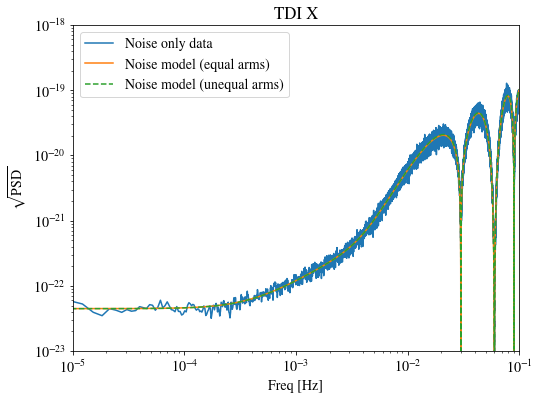

In [11]:
plt.figure(figsize=(8, 6))
plt.loglog(f, np.sqrt(psdX_noise), label="Noise only data")
plt.loglog(noise_model.freq, np.sqrt(s_x_eq), 
           label="Noise model (equal arms)")
plt.loglog(noise_model.freq, np.sqrt(s_x_uneq), 
           label="Noise model (unequal arms)", linestyle='dashed')
plt.axis([1e-5, 1e-1, 1e-23, 1e-18])
plt.ylabel("$\sqrt{\mathrm{PSD}}$")
plt.xlabel("Freq [Hz]")
plt.title("TDI X")
plt.legend(loc='upper left')

In [12]:
# Data periodogram
f, psdXY_noise =  signal.csd(tdi_xyz_noise[:, 0], tdi_xyz_noise[:, 1], fs=1.0/dt, window='blackman', nperseg=256*256)
# Analytical models
s_xy_eq = noise_model.psd(option="XY", tdi2=True, equal_arms=True)
s_xy_uneq = noise_model.psd(option="XY", tdi2=True, equal_arms=False)

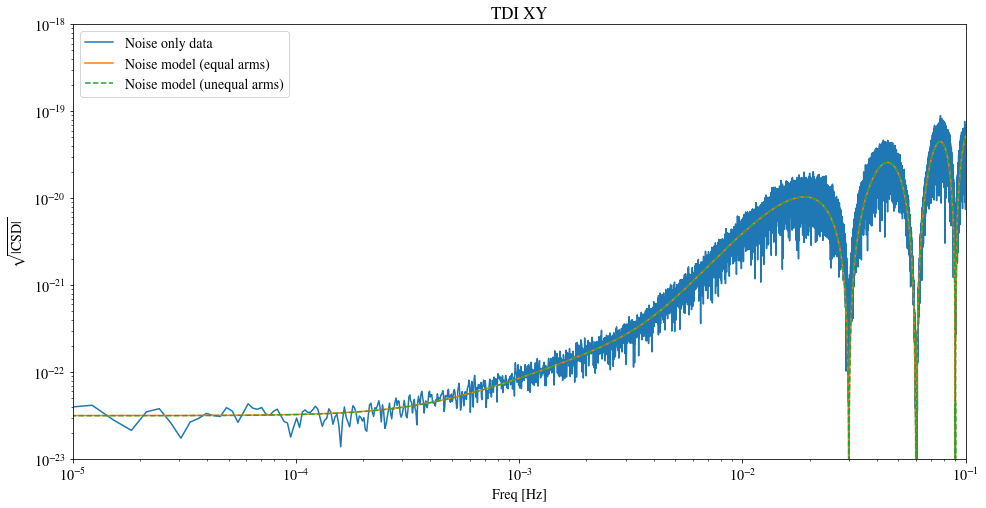

In [13]:
plt.figure(figsize=(16, 8))
plt.loglog(f, np.sqrt(np.abs(psdXY_noise)), label="Noise only data")
plt.loglog(f[f>0], np.sqrt(np.abs(s_xy_eq)), label="Noise model (equal arms)")
plt.loglog(f[f>0], np.sqrt(np.abs(s_xy_uneq)), label="Noise model (unequal arms)", linestyle='dashed')
plt.axis([1e-5, 1e-1, 1e-23, 1e-18])
plt.title("TDI XY")
plt.ylabel("$\sqrt{\mathrm{|CSD|}}$")
plt.xlabel("Freq [Hz]")
plt.legend(loc='upper left')

### 3.1 Compare analytical model and data for pseudo-orthogonal variables AET

In [14]:
# Transform data
tdi_aet_noise = dot_vect(aet_mat[np.newaxis, :, :], tdi_xyz_noise)

In [15]:
s_a_eq = noise_model.psd(option='A', tdi2=True, equal_arms=True)
s_a_uneq = noise_model.psd(option='A', tdi2=True, equal_arms=False)

/Users/qb265383/opt/anaconda3/envs/ldcdev/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


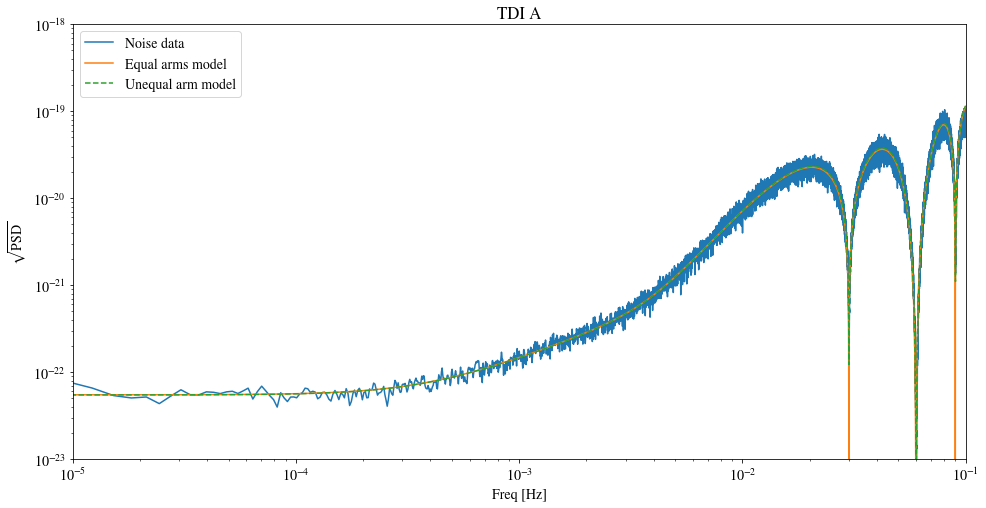

In [16]:
f, psdA_noise =  signal.welch(tdi_aet_noise[:, 0], fs=1.0/dt, window='blackman', nperseg=256*256)

plt.figure(figsize=(16, 8))
plt.loglog(f, np.sqrt(psdA_noise), label="Noise data")
plt.loglog(noise_model.freq, np.sqrt(s_a_eq), label="Equal arms model")
plt.loglog(noise_model.freq, np.sqrt(s_a_uneq), # * np.abs(filter_tf), 
           label="Unequal arm model",
           linestyle='dashed')
plt.axis([1e-5, 1e-1, 1e-23, 1e-18])
plt.title("TDI A")
plt.ylabel("$\sqrt{\mathrm{PSD}}$")
plt.xlabel("Freq [Hz]")
plt.legend(loc='upper left')

In [17]:
# Compute analytical model assuming equal arms
s_t_eq = noise_model.psd(option='T', tdi2=True, equal_arms=True)
s_t_uneq = noise_model.psd(option='T', tdi2=True, equal_arms=False)
# Compute data periodogram
f, psdT_noise =  signal.welch(tdi_aet_noise[:, 2], fs=1.0/dt, window='hanning', nperseg=256*256)

In [18]:
print(s_t_uneq)

[1.68550792e-50-4.17285692e-68j 1.68580242e-50+9.27301538e-69j
 1.68629254e-50+1.85460308e-68j ... 5.55824712e-39+1.22349459e-55j
 5.55819711e-39+8.15663058e-56j 5.55814490e-39+0.00000000e+00j]


/Users/qb265383/opt/anaconda3/envs/ldcdev/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


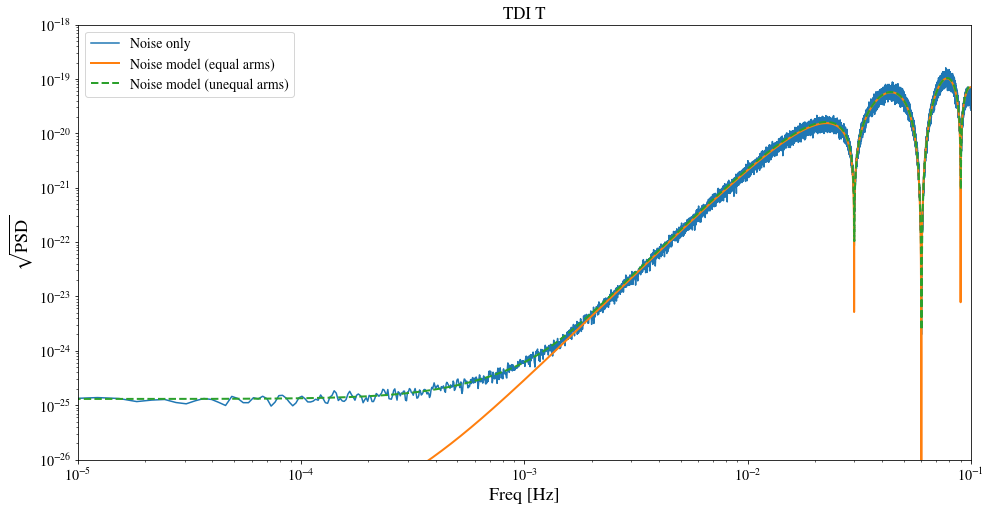

In [19]:
plt.figure(figsize=(16, 8))
plt.subplot(111)
plt.loglog(f, np.sqrt(psdT_noise), label="Noise only", rasterized=True)
plt.loglog(noise_model.freq, np.sqrt(s_t_eq), label="Noise model (equal arms)", lw=2, rasterized=True)
plt.loglog(noise_model.freq, np.sqrt(s_t_uneq), label="Noise model (unequal arms)", linestyle='dashed', lw=2, rasterized=True)
plt.axis([1e-5, 1e-1, 1e-26, 1e-18])
plt.title("TDI T")
plt.ylabel("$\sqrt{\mathrm{PSD}}$", fontsize=18)
plt.xlabel("Freq [Hz]", fontsize=18)
plt.legend(loc='upper left')
plt.savefig("spritz_t_psd_comparisons.pdf")

/Users/qb265383/opt/anaconda3/envs/ldcdev/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


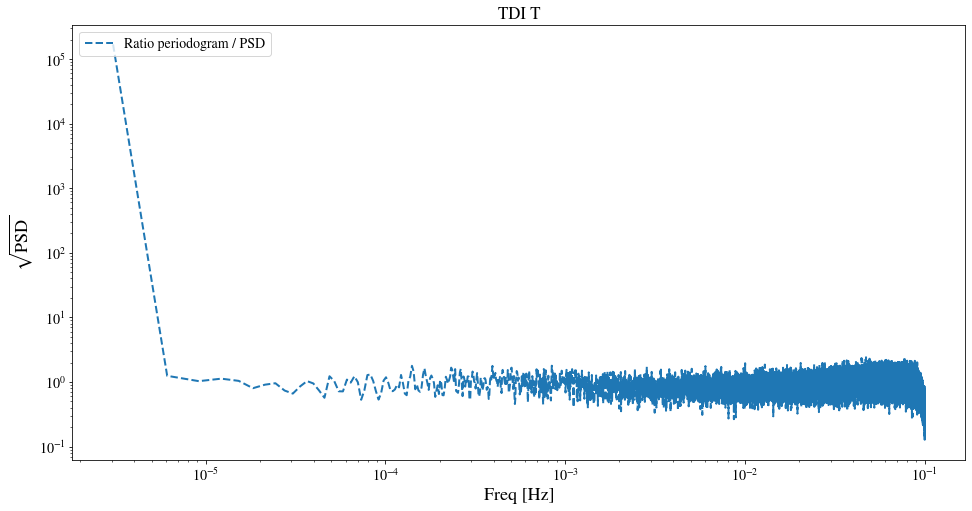

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(111)
plt.loglog(noise_model.freq, psdT_noise[f>0]/s_t_uneq, label="Ratio periodogram / PSD", 
           linestyle='dashed', lw=2, rasterized=True)
plt.title("TDI T")
plt.ylabel("$\sqrt{\mathrm{PSD}}$", fontsize=18)
plt.xlabel("Freq [Hz]", fontsize=18)
plt.legend(loc='upper left')
plt.savefig("spritz_t_psd_comparisons.pdf")